In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Configuration des styles pour les visualisations
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

In [2]:

input_path = "/kaggle/input/cardiovascular-disease-dataset/"

try:
    # Essayez de charger les données avec différents noms de fichiers possibles
    df = pd.read_csv(input_path + "cardio_train.csv", sep=';')
except:
    try:
        df = pd.read_csv(input_path + "train.csv")
    except:
        df = pd.read_csv(input_path + "cardio.csv")

# Afficher les premières lignes pour vérification
print("Shape du dataset:", df.shape)
df.head()

Shape du dataset: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
#Nettoyage et préparation des données
# Conversion de l'âge de jours en années
if 'age' in df.columns:
    df['age'] = df['age'] // 365

# Vérification des colonnes disponibles
print("Colonnes disponibles:", df.columns.tolist())

Colonnes disponibles: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [4]:
# Gestion des IDs 
if 'id' in df.columns:
    ids = df['id']
else:
    # Créer un ID artificiel si la colonne n'existe pas
    ids = pd.Series(range(1, len(df)+1), name='id')

# Vérifier la colonne cible
target_col = 'cardio' if 'cardio' in df.columns else 'target'
print("Colonne cible:", target_col)


Colonne cible: cardio


In [5]:
# Traitement des valeurs aberrantes
def clean_data(df):
    # Pression artérielle
    if 'ap_hi' in df.columns and 'ap_lo' in df.columns:
        df = df[(df['ap_hi'] >= 80) & (df['ap_hi'] <= 200)]
        df = df[(df['ap_lo'] >= 50) & (df['ap_lo'] <= 120)]
        df = df[df['ap_hi'] >= df['ap_lo']]
    
    # Création de nouvelles caractéristiques
    if 'weight' in df.columns and 'height' in df.columns:
        df['bmi'] = df['weight'] / (df['height']/100)**2
    if 'ap_hi' in df.columns and 'ap_lo' in df.columns:
        df['bp_diff'] = df['ap_hi'] - df['ap_lo']
        df['bp_mean'] = (df['ap_hi'] + df['ap_lo']) / 2
    
    return df

df = clean_data(df)

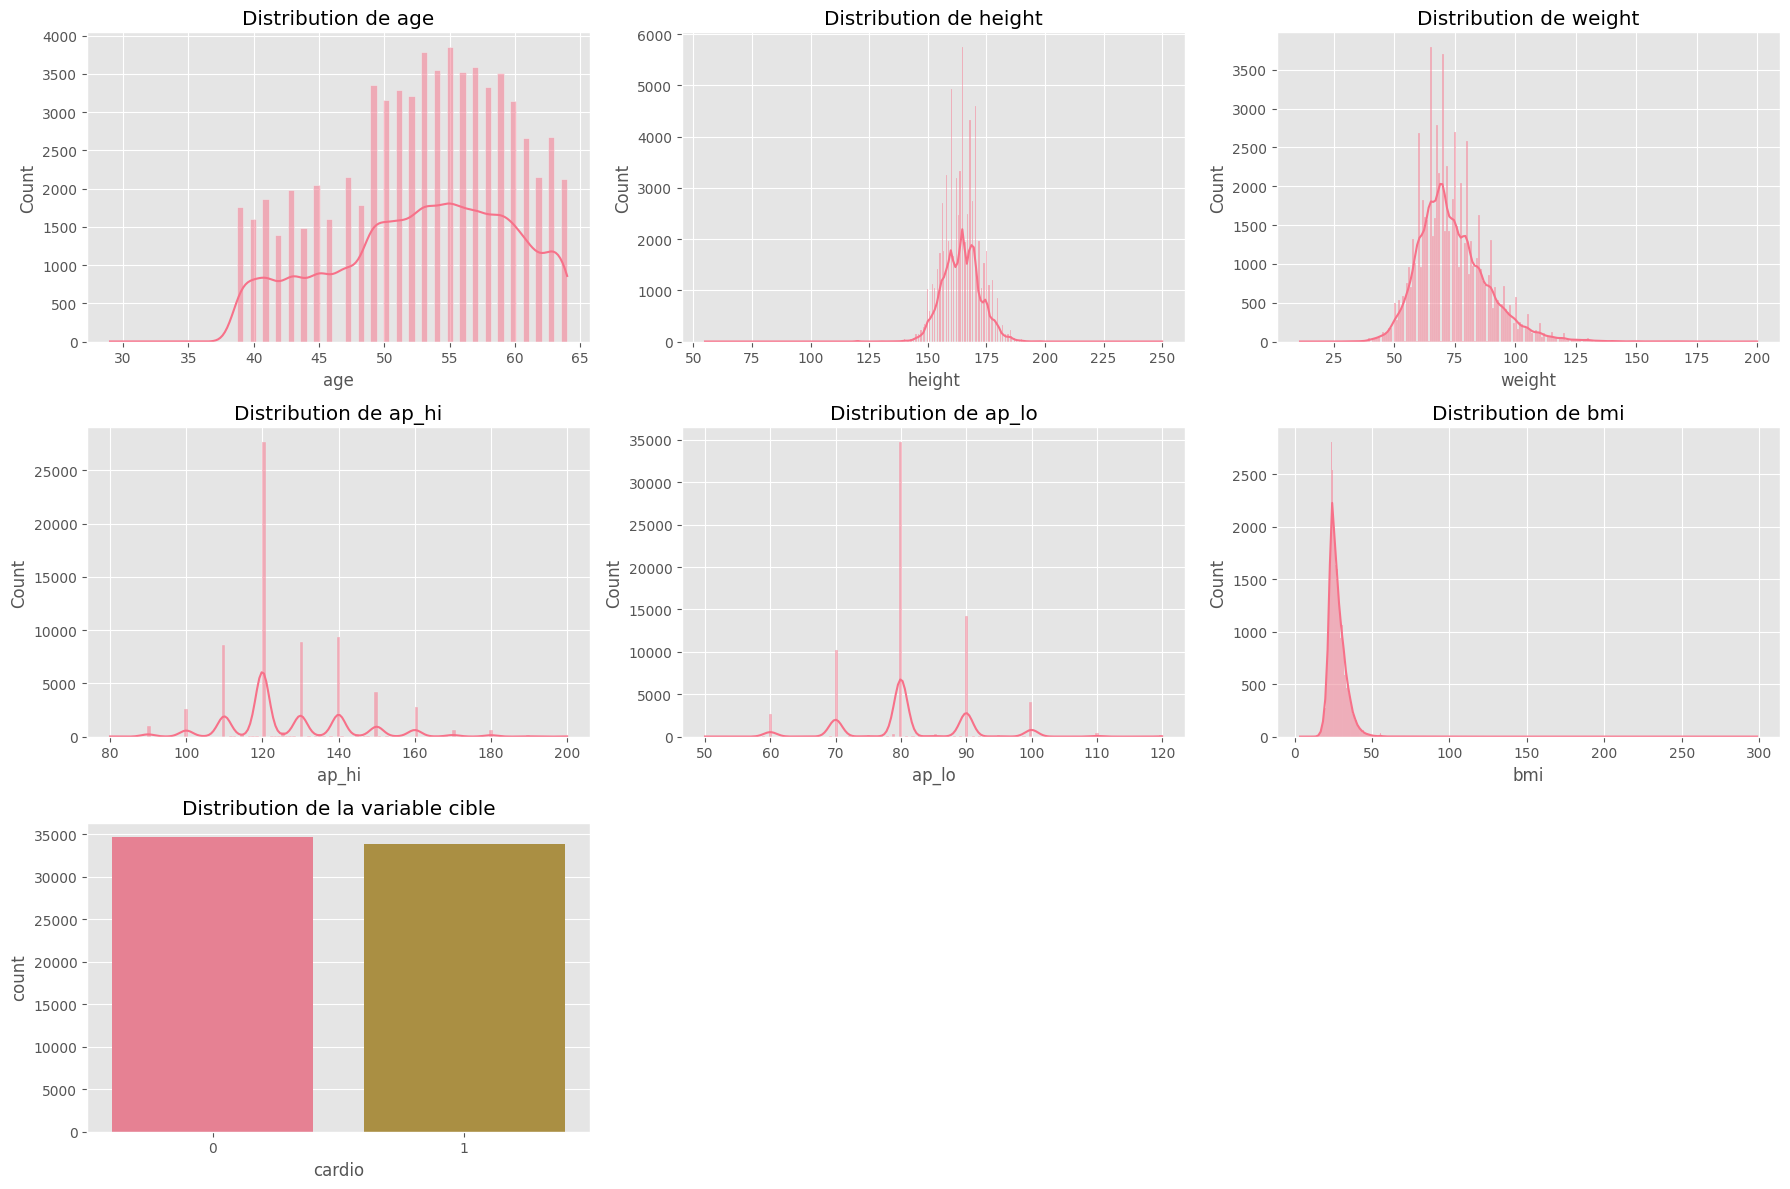

In [6]:
#Exploration des données 
def plot_distributions(df):
    plt.figure(figsize=(18, 12))
    
    # Distribution des variables numériques
    num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']
    num_cols = [col for col in num_cols if col in df.columns]
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution de {col}')
    
    # Distribution de la cible
    plt.subplot(3, 3, i+1)
    sns.countplot(x=target_col, data=df)
    plt.title('Distribution de la variable cible')
    
    plt.tight_layout()
    plt.show()

plot_distributions(df)

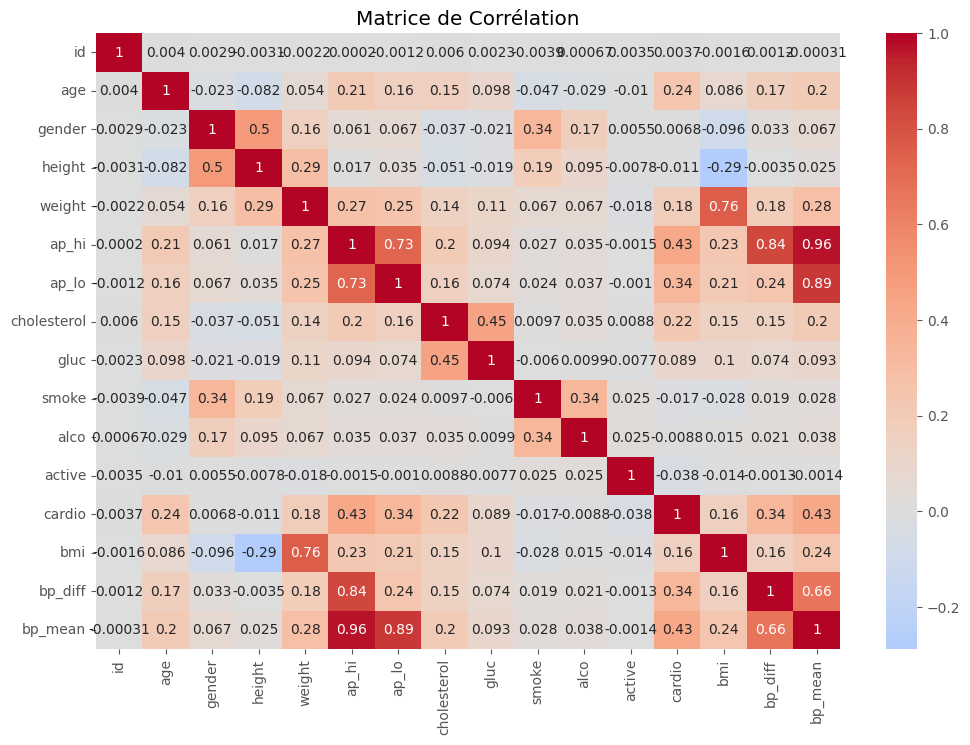

In [7]:
# Matrice de corrélation
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()


In [8]:
#Préparation des données pour le modèle
# Séparation des caractéristiques et de la cible
X = df.drop([target_col, 'id'], axis=1, errors='ignore')
y = df[target_col]

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gestion du déséquilibre de classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [9]:
#Modélisation 
def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test):
    # Recherche des meilleurs hyperparamètres
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Meilleur modèle
    best_model = grid_search.best_estimator_
    
    # Prédictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Évaluation
    print("\n" + "="*50)
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    print(f"Score F1: {f1_score(y_test, y_pred):.4f}")
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de Confusion')
    plt.show()
    
    return best_model, grid_search.best_score_


RÉGRESSION LOGISTIQUE
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres: {'C': 100, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Score F1: 0.7079

Rapport de classification:
              precision    recall  f1-score   support

           0       0.71      0.79      0.74     10403
           1       0.75      0.67      0.71     10168

    accuracy                           0.73     20571
   macro avg       0.73      0.73      0.73     20571
weighted avg       0.73      0.73      0.73     20571



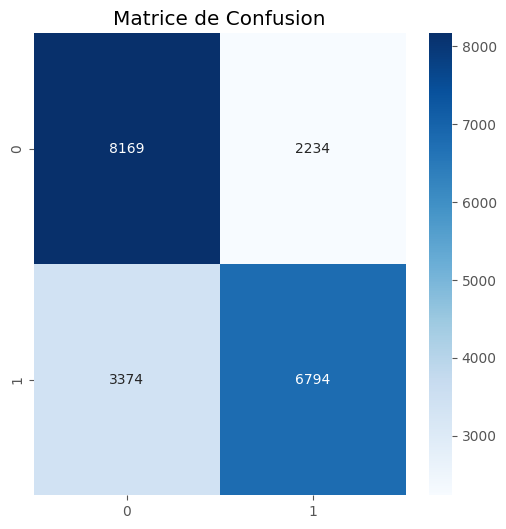

In [10]:
# 1. Régression Logistique
print("\n" + "="*50)
print("RÉGRESSION LOGISTIQUE")
print("="*50)
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}
log_reg, log_reg_score = train_and_evaluate(
    LogisticRegression(random_state=42),
    log_reg_params,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)


ARBRE DE DÉCISION
Fitting 5 folds for each of 126 candidates, totalling 630 fits

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Score F1: 0.7066

Rapport de classification:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75     10403
           1       0.76      0.66      0.71     10168

    accuracy                           0.73     20571
   macro avg       0.73      0.73      0.73     20571
weighted avg       0.73      0.73      0.73     20571



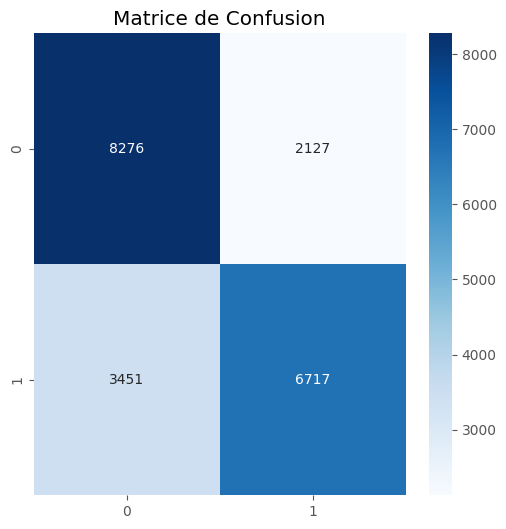

In [11]:
# 2. Arbre de Décision
print("\n" + "="*50)
print("ARBRE DE DÉCISION")
print("="*50)
dt_params = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dt, dt_score = train_and_evaluate(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)


FORÊT ALÉATOIRE
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Meilleurs paramètres: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Score F1: 0.7174

Rapport de classification:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10403
           1       0.75      0.69      0.72     10168

    accuracy                           0.73     20571
   macro avg       0.73      0.73      0.73     20571
weighted avg       0.73      0.73      0.73     20571



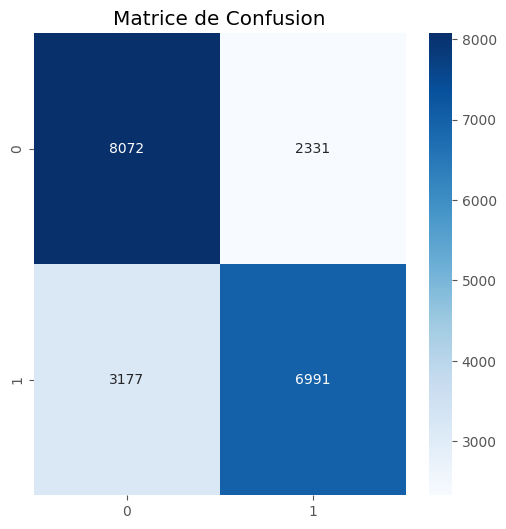

In [12]:
# 3. Forêt Aléatoire
print("\n" + "="*50)
print("FORÊT ALÉATOIRE")
print("="*50)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf, rf_score = train_and_evaluate(
    RandomForestClassifier(random_state=42),
    rf_params,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)

In [13]:
#Sélection du meilleur modèle
models = {
    'Régression Logistique': log_reg_score,
    'Arbre de Décision': dt_score,
    'Forêt Aléatoire': rf_score
}

best_model_name = max(models, key=models.get)
best_model = {
    'Régression Logistique': log_reg,
    'Arbre de Décision': dt,
    'Forêt Aléatoire': rf
}[best_model_name]

print("\n" + "="*50)
print("COMPARAISON DES MODÈLES")
print("="*50)
for name, score in models.items():
    print(f"{name}: Score F1 = {score:.4f}")

print(f"\nLe meilleur modèle est: {best_model_name} avec un score F1 de {models[best_model_name]:.4f}")



COMPARAISON DES MODÈLES
Régression Logistique: Score F1 = 0.7112
Arbre de Décision: Score F1 = 0.7152
Forêt Aléatoire: Score F1 = 0.7202

Le meilleur modèle est: Forêt Aléatoire avec un score F1 de 0.7202
